In [16]:
import pandas as pd
import xarray as xr
from glob import glob
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.patches import Arrow
from cmod5n import cmod5n_forward, cmod5n_inverse
# from ../utils.cmod5n import cmod5n_forward, cmod5n_inverse

In [3]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

dfwv1 = pd.read_parquet("../results/wv1_results.parquet")
dfwv2 = pd.read_parquet("../results/wv2_results.parquet")

In [4]:
fn_fullpath = f"{glob('../processed_data/Sentinel1/WV/2021/*.nc')[-1]}"
fn = fn_fullpath.split("\\")[-1]

ds = xr.open_dataset(fn_fullpath)

np.median(ds.incidence.values)

fn

'S1A_WV_SLC__1SSV_20211204T155812_20211204T160647_040861_04D9FC_F9F6__WV_017.nc'

In [5]:
df1[df1.renamed_filename == fn]

,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,prob_2,class_3,...,band1_rel_error_mean,band1_rmse,band2_wspd_mean,band2_wspd_median,band2_error_mean,band2_error_median,band2_abs_error_mean,band2_rel_error_mean,band2_rmse,phi_bins
174,17,wv1,-146.181079922 42.271247523,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.996547,IB,0.002811,AF,...,-0.998192,18.072377,0.011308,-0.039062,-18.093251,-18.143621,18.093251,-0.999375,18.093477,"[-25, -20)"


In [6]:
df2[df2.renamed_filename == fn]

,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,prob_2,class_3,...,sigma0_cmod_column_var,sigma0_cmod_skew,sigma0_cmod_kurtosis,wspd_median,wspd_var,wspd_skewness,wspd_kurtosis,residual,residual_normalized,phi_bins


In [7]:
def compute_2d_fft(sigma0):
    """Compute 2D FFT of sigma0 values."""
    
    sigma0_clean = sigma0.copy()
    if np.isnan(sigma0_clean).any():
        sigma0_clean[np.isnan(sigma0_clean)] = 0
    
    fft_data = np.fft.fft2(sigma0_clean)
    psd_2d = np.abs(fft_data)**2
    
    freqx = np.fft.fftfreq(sigma0.shape[1])
    freqy = np.fft.fftfreq(sigma0.shape[0])
    kx, ky = np.meshgrid(freqx, freqy)
    kmagnitude = np.sqrt(kx**2 + ky**2)
    
    return fft_data, psd_2d, kx, ky, kmagnitude, sigma0_clean



In [8]:
fn_fullpath = f"{glob('../processed_data/Sentinel1/WV/2021/*.nc')[1]}"
fn = fn_fullpath.split("\\")[-1]

ds = xr.open_dataset(fn_fullpath)

_, psd, _, _, _, sigma0_clean = compute_2d_fft(ds.sigma0.values[0])
start_date = ds.start_date[:-7]

fn_fullpath = fn_fullpath[3:].replace("\\", "/")
fn_fullpath

'processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1SSV_20211204T150725_20211204T151630_040860_04D9F6_0087__WV_013.nc'

In [9]:
psd.shape

(203, 210)

146 146


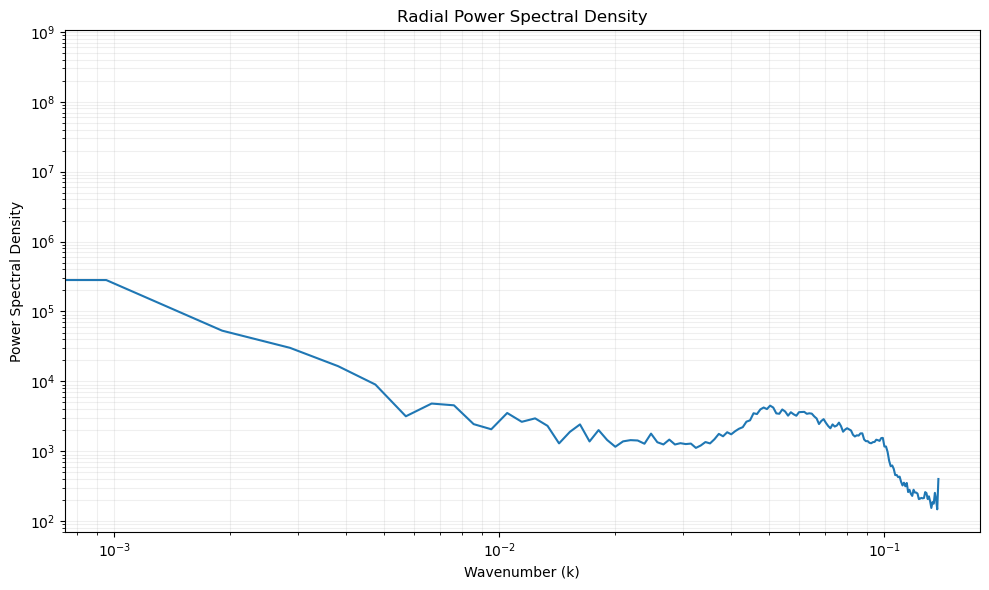

In [10]:
# Shift zero frequency to center
psd_centered = np.fft.fftshift(psd)

# Calculate radial profile
def radial_profile(data, center=None):
    y, x = np.indices(data.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)
    
    tbin = np.bincount(r.ravel(), weights=data.ravel())
    nr = np.bincount(r.ravel())
    
    radial_profile = tbin / nr
    
    return np.arange(len(radial_profile)), radial_profile

distances, radial_psd = radial_profile(psd_centered)

print(len(distances), len(radial_psd))

min_length = min(len(distances), len(radial_psd))
distances = distances[:min_length]
radial_psd = radial_psd[:min_length]

pixel_size = 5
k_values = distances * (1.0 / (pixel_size * max(psd.shape)))

plt.figure(figsize=(10, 6))
plt.loglog(k_values, radial_psd)
plt.xlabel('Wavenumber (k)')
plt.ylabel('Power Spectral Density')
plt.title('Radial Power Spectral Density')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

In [14]:
def rename_filename(s):
    yr = s[17:21]
    if int(yr) not in [2020, 2021]:
        raise ValueError("Year not in range")
    
    return f"processed_data/Sentinel1/WV/{yr}/{s}"
    

In [12]:
row = dfwv1[dfwv1["sar_filepath"].str.replace("/projects/fluxsar/data", "processed_data") == fn_fullpath]

In [13]:
v = np.array(row["era5_wspd"])
phi = np.array(row["phi_nominal"])
theta = ds.incidence.values
sigma_cmod = cmod5n_forward(v, phi, theta)
sigma_sar = sigma0_clean
gh = np.median(ds.ground_heading.values).astype(float)
wdir = row["era5_wdir"].values.astype(float)

fft_sar, psd_sar, kx_sar, ky_sar, kmag_sar, _ = compute_2d_fft(sigma_sar)
fft_cmod, psd_cmod, kx_cmod, ky_cmod, kmag_cmod, _ = compute_2d_fft(sigma_cmod)

146 146


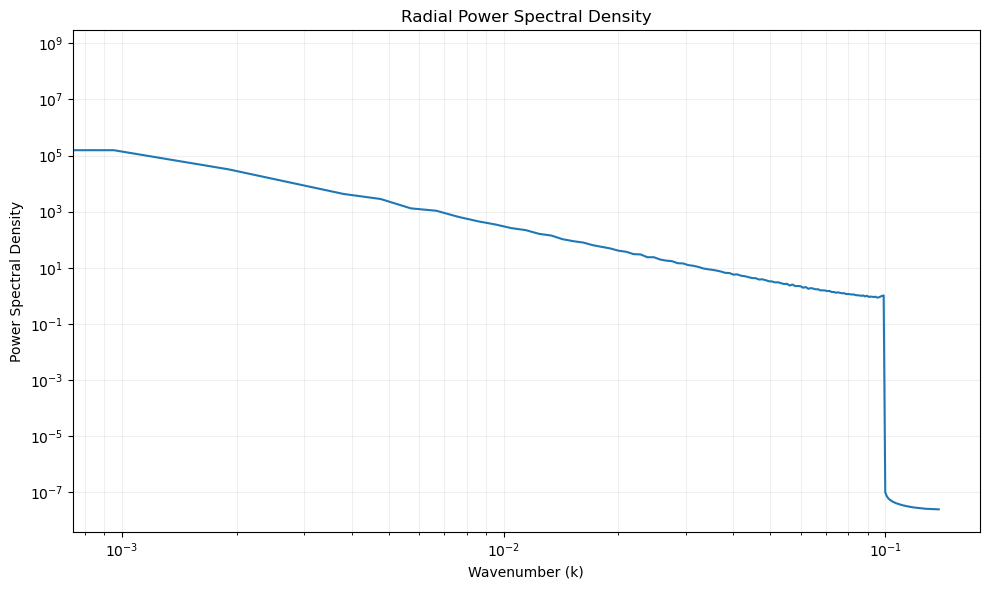

In [ ]:
psd_cmod_centered = np.fft.fftshift(psd_cmod)
distances, radial_psd = radial_profile(psd_cmod_centered)

print(len(distances), len(radial_psd))

min_length = min(len(distances), len(radial_psd))
distances = distances[:min_length]
radial_psd = radial_psd[:min_length]

pixel_size = 5
k_values = distances * (1.0 / (pixel_size * max(psd_cmod.shape)))

plt.figure(figsize=(10, 6))
plt.loglog(k_values, radial_psd)
plt.xlabel('Wavenumber (k)')
plt.ylabel('Power Spectral Density')
plt.title('Radial Power Spectral Density')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()


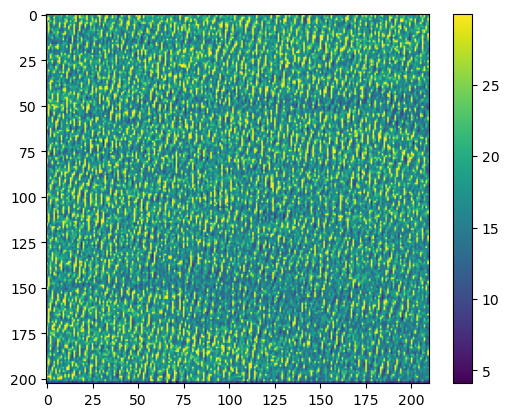

In [ ]:
plt.imshow(cmod5n_inverse(sigma_sar, phi, theta))
plt.colorbar()  

In [20]:
cmod5n_inverse?

Signature: cmod5n_inverse(sigma0_obs, phi, incidence, iterations=10)
Docstring:
!     ---------
!     cmod5n_inverse(sigma0_obs, phi, incidence, iterations)
!         inputs:
!              sigma0_obs     Normalized Radar Cross Section [linear units]
!              phi   in [deg] angle between azimuth and wind direction
!                    (= D - AZM)
!              incidence in [deg] incidence angle
!              iterations: number of iterations to run
!         output:
!              Wind speed, 10 m, neutral stratification
!
!        All inputs must be Numpy arrays of equal sizes
!
!    This function iterates the forward CMOD5N function
!    until agreement with input (observed) sigma0 values
!---------------------------------------------------------------------
   
File:      c:\users\guilhermealvarenga\code\msc-thesis\notebooks\cmod5n.py
Type:      function

In [104]:
def band_filter(fft_data, kmagnitude, kmin, kmax):
    """Apply band-pass filter to FFT data."""
    # Create mask for band-pass filter
    mask = (kmagnitude >= kmin) & (kmagnitude < kmax)
    
    # Apply filter in frequency domain
    fft_filtered = np.zeros_like(fft_data, dtype=complex)
    fft_filtered[mask] = fft_data[mask]
    
    # Invert back to spatial domain
    filtered_sigma0 = np.real(np.fft.ifft2(fft_filtered))
    
    return filtered_sigma0


In [105]:
band0a_cmod = band_filter(fft_cmod, kmag_cmod, 0, 0.0333)
band0b_cmod = band_filter(fft_cmod, kmag_cmod, 0.0333, 0.0666)
band0c_cmod = band_filter(fft_cmod, kmag_cmod, 0.0666, 0.1)
band1_cmod = band_filter(fft_cmod, kmag_cmod, 0.1, 0.3)
band2_cmod = band_filter(fft_cmod, kmag_cmod, 0.3, np.inf)

band0a_sar = band_filter(fft_sar, kmag_sar, 0, 0.0333)
band0b_sar = band_filter(fft_sar, kmag_sar, 0.0333, 0.0666)
band0c_sar = band_filter(fft_sar, kmag_sar, 0.0666, 0.1)
band1_sar = band_filter(fft_sar, kmag_sar, 0.1, 0.3)
band2_sar = band_filter(fft_sar, kmag_sar, 0.3, np.inf)

In [106]:
ratio_band0a = np.nanmean(band0a_cmod / np.where(band0a_sar == 0, np.nan, band0a_sar))
ratio_band0b = np.nanmean(band0b_cmod / np.where(band0b_sar == 0, np.nan, band0b_sar))
ratio_band0c = np.nanmean(band0c_cmod / np.where(band0c_sar == 0, np.nan, band0c_sar))
ratio_band1 = np.nanmean(band1_cmod / np.where(band1_sar == 0, np.nan, band1_sar))
ratio_band2 = np.nanmean(band2_cmod / np.where(band2_sar == 0, np.nan, band2_sar))

In [67]:
def plot_sigma0(sigma0, ground_heading, wind_direction, title="Sigma0"):
    """Plot the sigma0 values with a north arrow.
    
    Args:
        sigma0: The sigma0 image array
        title: Plot title
        ground_heading: Ground heading in degrees (-180 to 180)
    """
    _, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(sigma0, cmap='gray', aspect='auto')
    plt.colorbar(im, label='Sigma0')
    ax.set_title(f"{title}")
    ax.set_xlabel('Range Pixel')
    ax.set_ylabel('Azimuth Pixel')
    
    arrow_length = min(sigma0.shape) * 0.1
    arrow_x = sigma0.shape[1] * 0.05
    arrow_y = sigma0.shape[0] * 0.2
    dx = arrow_length * np.sin(np.radians(-ground_heading))
    dy = -arrow_length * np.cos(np.radians(-ground_heading))
    
    arrow = Arrow(arrow_x, arrow_y, dx, dy, width=arrow_length*0.3, color='red')
    ax.add_patch(arrow)
    ax.text(arrow_x + dx + 5, arrow_y + dy, 'N', color='red', fontsize=12, fontweight='bold')

    wind_arrow_x = sigma0.shape[1] * 0.8
    wind_arrow_y = sigma0.shape[0] * 0.4
    
    wind_dx = arrow_length * np.sin(np.radians(-wind_direction))
    wind_dy = -arrow_length * np.cos(np.radians(-wind_direction))

    wind_arrow = Arrow(wind_arrow_x, wind_arrow_y, wind_dx, wind_dy, width=arrow_length*0.3, color='blue')
    ax.add_patch(wind_arrow)
    ax.text(wind_arrow_x + wind_dx + 10, wind_arrow_y + wind_dy - 2, 'W', color='blue', fontsize=12, fontweight='bold')
    
    plt.show()

def plot_psd(psd_2d, ground_heading, wdir, title="2D Power Spectral Density"):
    """Plot the 2D Power Spectral Density with a north arrow.
    
    Args:
        psd_2d: The PSD 2D array
        title: Plot title
        ground_heading: Ground heading in degrees (-180 to 180)
    """
    _, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(np.log(psd_2d), cmap='gray', aspect='auto')
    plt.colorbar(im, label='Log Power Spectral Density')
    ax.set_title(title)
    ax.set_xlabel('kx [1/m]')
    ax.set_ylabel('ky [1/m]')
    
    center_x = psd_2d.shape[1] // 2
    center_y = psd_2d.shape[0] // 2
    arrow_length = min(psd_2d.shape) * 0.15
    
    north_angle = 90 - ground_heading
    dx = arrow_length * np.cos(north_angle)
    dy = -arrow_length * np.sin(north_angle) 
    
    arrow = Arrow(center_x, center_y, dx, dy, width=arrow_length*0.3, color='red')
    ax.add_patch(arrow)
    ax.text(center_x + dx + 5, center_y + dy + 5, 'N', color='red', fontsize=12, fontweight='bold')

    wind_dx = arrow_length * 0.5 * np.cos(np.radians(-wdir))
    wind_dy = -arrow_length * 0.5 * np.sin(np.radians(-wdir))  

    wind_arrow = Arrow(center_x, center_y, wind_dx, wind_dy, width=arrow_length*0.3, color='blue')
    ax.add_patch(wind_arrow)
    ax.text(center_x + wind_dx + 5, center_x + wind_dy - 2, 'W', color='blue', fontsize=12, fontweight='bold')
    
    plt.show()

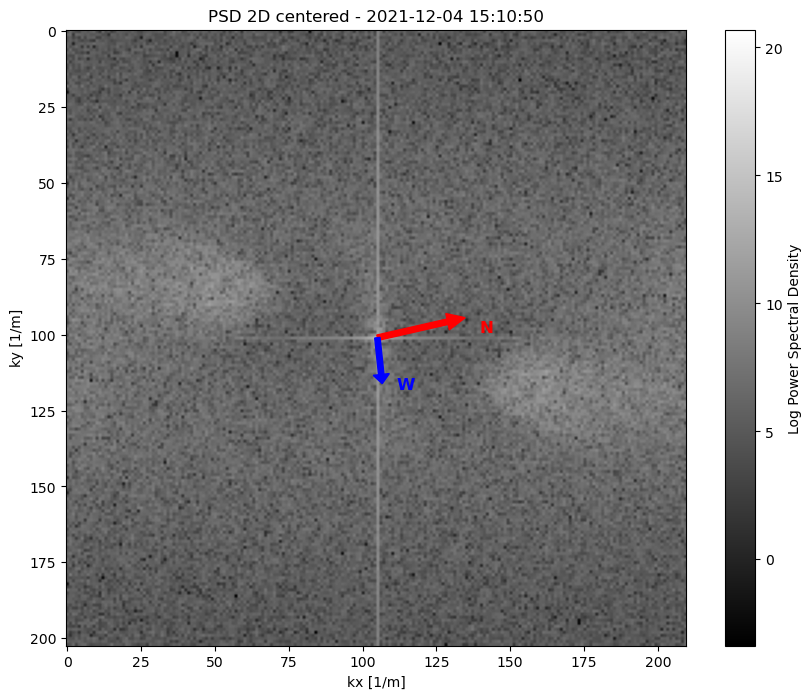

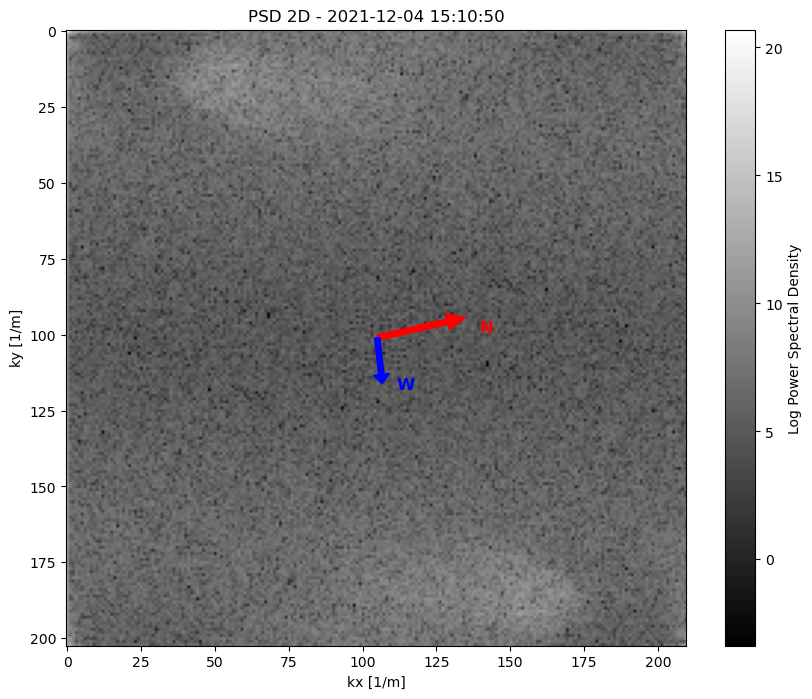

In [110]:
# plot_sigma0(sigma0_clean, gh, wdir, title=f"Sigma0 - {start_date}")
# plot_psd(psd, gh, wdir, title=f"PSD 2D - {start_date}")

plot_psd(psd_centered, gh, wdir, title=f"PSD 2D centered - {start_date}")
plot_psd(psd, gh, wdir, title=f"PSD 2D - {start_date}")

In [ ]:
def plot_ratios(df_results, wv, print_stats=False, percentile_threshold=98):
    """
    Plot transfer function ratios with outlier handling.
    
    Parameters:
    -----------
    df_results : pandas.DataFrame
        DataFrame containing the analysis results
    wv : str
        Wave mode identifier (e.g., 'wv1', 'wv2')
    percentile_threshold : float
        Percentile threshold for outlier removal (e.g., 98 means keep values between 1st and 98th percentile)
    """
    
    band_labels = ['Band 0a (k < 0.0333)', 'Band 0b (0.0333 ≤ k < 0.0666)', 
                   'Band 0c (0.0666 ≤ k < 0.1)', 'Band 1 (0.1 ≤ k < 0.3)', 
                   'Band 2 (k ≥ 0.3)']

    # Extract ratios
    ratio0a = df_results['ratio_band0a']
    ratio0b = df_results['ratio_band0b']
    ratio0c = df_results['ratio_band0c']
    ratio1 = df_results['ratio_band1']
    ratio2 = df_results['ratio_band2']
    
    original_ratios = [ratio0a, ratio0b, ratio0c, ratio1, ratio2]
    
    cleaned_ratios = []
    
    for ratio in original_ratios:
        clean_ratio = ratio.copy()
        
        clean_ratio = clean_ratio.dropna()
        
        if len(clean_ratio) > 0:
            lower_threshold = np.percentile(clean_ratio, 100 - percentile_threshold)
            upper_threshold = np.percentile(clean_ratio, percentile_threshold)
            
            clean_ratio = clean_ratio[(clean_ratio >= lower_threshold) & 
                                      (clean_ratio <= upper_threshold)]
        
        cleaned_ratios.append(clean_ratio)
    

    plt.figure(figsize=(12, 6))
    plt.boxplot(original_ratios, tick_labels=band_labels)
    plt.title(f'Transfer Function Ratios by Wavenumber Band ({wv.upper()}) - With Outliers')
    plt.ylabel('Model-to-Observed Ratio')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)  # Reference line at ratio=1
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../images/transfer_function_ratios_{wv}_with_outliers.png', dpi=300)
    plt.close()
    
    # 2. Cleaned plot without extreme outliers
    plt.figure(figsize=(12, 6))
    plt.boxplot(cleaned_ratios, tick_labels=band_labels)
    plt.title(f'Transfer Function Ratios by Wavenumber Band ({wv.upper()}) - Outliers Removed')
    plt.ylabel('Model-to-Observed Ratio')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)  # Reference line at ratio=1
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../images/transfer_function_ratios_{wv}_cleaned.png', dpi=300)
    plt.close()
    
    # 3. Tighter view focused on central tendencies
    plt.figure(figsize=(12, 6))
    plt.boxplot(cleaned_ratios, tick_labels=band_labels)
    plt.title(f'Transfer Function Ratios by Wavenumber Band ({wv.upper()}) - Tight View')
    plt.ylabel('Model-to-Observed Ratio')
    
    # Calculate appropriate y-axis limits based on data
    all_values = []
    for ratio in cleaned_ratios:
        all_values.extend(ratio.values)
    
    if len(all_values) > 0:
        q1 = np.percentile(all_values, 25)
        q3 = np.percentile(all_values, 75)
        iqr = q3 - q1
        y_min = max(0, q1 - 1.5 * iqr)
        y_max = 2
        plt.ylim([y_min, y_max])
    
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../images/transfer_function_ratios_{wv}_tight_view.png', dpi=300)
    plt.close()
    
    if print_stats:
        # Print summary statistics for each band
        print(f"\nSummary Statistics for {wv.upper()} after Outlier Removal:")
        print("-" * 50)
        for i, (ratio, label) in enumerate(zip(cleaned_ratios, band_labels)):
            if len(ratio) > 0:
                print(f"{label}:")
                print(f"  Mean: {ratio.mean():.4f}")
                print(f"  Median: {ratio.median():.4f}")
                print(f"  Std Dev: {ratio.std():.4f}")
                print(f"  Count: {len(ratio)}")
                print(f"  Range: [{ratio.min():.4f}, {ratio.max():.4f}]")
                print()
    
    return cleaned_ratios

In [ ]:
cleaned_ratios_wv1 = plot_ratios(dfwv1, 'wv1', percentile_threshold=98)
cleaned_ratios_wv2 = plot_ratios(dfwv2, 'wv2', percentile_threshold=98)

In [18]:
def plot_sensitivity(df_results, wv):
        
        band_labels = ['Band 0a (k < 0.0333)', 'Band 0b (0.0333 ≤ k < 0.0666)', 
                    'Band 0c (0.0666 ≤ k < 0.1)', 'Band 1 (0.1 ≤ k < 0.3)', 
                    'Band 2 (k ≥ 0.3)']
        
        # 2. Scale-Dependent Sensitivity
        sensitivity0a = df_results['sensitivity_metrics'].apply(lambda x: x['band0a'])
        sensitivity0b = df_results['sensitivity_metrics'].apply(lambda x: x['band0b'])
        sensitivity0c = df_results['sensitivity_metrics'].apply(lambda x: x['band0c'])
        sensitivity1 = df_results['sensitivity_metrics'].apply(lambda x: x['band1'])
        sensitivity2 = df_results['sensitivity_metrics'].apply(lambda x: x['band2'])
        
        plt.figure(figsize=(12, 6))
        plt.boxplot([sensitivity0a, sensitivity0b, sensitivity0c, sensitivity1, sensitivity2], tick_labels=band_labels)
        plt.title(f'Scale-Dependent Sensitivity by Wavenumber Band {wv.upper()}')
        plt.ylabel('Sensitivity (∆sigma0/∆wspd)')
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'../images/scale_sensitivity_{wv}.png', dpi=300)
        plt.close()

In [19]:
plot_sensitivity(dfwv1, 'wv1')
plot_sensitivity(dfwv2, 'wv2')

In [20]:
def plot_cross_scale_analysis(df_results, wv):
        band_labels = ['Band 0a (k < 0.0333)', 'Band 0b (0.0333 ≤ k < 0.0666)', 
                    'Band 0c (0.0666 ≤ k < 0.1)', 'Band 1 (0.1 ≤ k < 0.3)', 
                    'Band 2 (k ≥ 0.3)']
        
        bias0a = df_results['errors_band0a'].apply(lambda x: x['bias'])
        bias0b = df_results['errors_band0b'].apply(lambda x: x['bias'])
        bias0c = df_results['errors_band0c'].apply(lambda x: x['bias'])
        bias1 = df_results['errors_band1'].apply(lambda x: x['bias'])
        bias2 = df_results['errors_band2'].apply(lambda x: x['bias'])
        
        mix1_bias = df_results['errors_mix1'].apply(lambda x: x['bias'])
        mix2_bias = df_results['errors_mix2'].apply(lambda x: x['bias'])
        mix3_bias = df_results['errors_mix3'].apply(lambda x: x['bias'])
        mix4_bias = df_results['errors_mix4'].apply(lambda x: x['bias'])

        no_mix = df_results["errors_no_mix"].apply(lambda x: x["bias"])
        
        plt.figure(figsize=(14, 8))
        mix_labels = ['Model(0a,0b)+Obs(0c,1,2)', 'Obs(0a,0b)+Model(0c,1,2)',
                    'Model(0a,0b,0c)+Obs(1,2)', 'Obs(0a,0b,0c)+Model(1,2)', "No Mix"]
        all_labels = [*band_labels, *mix_labels]
        
        plt.boxplot([bias0a, bias0b, bias0c, bias1, bias2, mix1_bias, mix2_bias, mix3_bias, mix4_bias, no_mix], 
                    tick_labels=all_labels)
        plt.title(f'Cross-Scale Impact Analysis {wv.upper()}: Bias')
        plt.ylabel('Bias (m/s)')
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'../images/cross_scale_impact_{wv}.png', dpi=300)
        plt.close()

In [21]:
plot_cross_scale_analysis(dfwv1, 'wv1')
plot_cross_scale_analysis(dfwv2, 'wv2')

In [ ]:
otp_file = glob("../results_v2/slurm-*.out")[0]

with open(otp_file, "r") as f:
    lines = f.readlines()

for line in lines:
    try:
        if line.strip()[1] != "%" and line.strip()[2] != "%" and line.strip()[3] != "%":
            print(line.strip())
    except:
        print(line.strip())
    

Loading data from parquet files...
Loaded 36921 WV1 records and 36996 WV2 records.
Checking SAR data paths...
After removing NaN paths: 36921 WV1 records and 36996 WV2 records.
Creating records for parallel processing...
Processing 36921 WV1 files in parallel using 48 processes...

Processing 36996 WV2 files in parallel...

Error reading SAR data: Unable to synchronously open file (file signature not found)
Processing completed in 3:25:39.129736.
Successfully processed 36921 WV1 files and 36995 WV2 files.
Saving results to parquet files...
Analyzing WV1 data...
Performing statistical tests for scale dependency...
Analyzing WV2 data...
Performing statistical tests for scale dependency...
Performing combined analysis...
Performing statistical tests for scale dependency...

Overall Scale Dependency Assessment:
WV1 Analysis: SCALE DEPENDENT
- Statistically significant differences in transfer function ratios
- Statistically significant differences in scale-dependent sensitivity
- Statistica

In [31]:
dfwv1.columns

Index(['sar_filepath', 'era5_wspd', 'era5_wdir', 'wspd_perturbed',
       'wdir_perturbed', 'phi_perturbed', 'phi_nominal',
       'wspd_perturbed_strong', 'wdir_perturbed_strong',
       'phi_perturbed_strong', 'sigma_sar_median', 'sigma_cmod_median',
       'errors_band0a', 'errors_band0b', 'errors_band0c', 'errors_band1',
       'errors_band2', 'ratio_band0a', 'ratio_band0b', 'ratio_band0c',
       'ratio_band1', 'ratio_band2', 'coherence_metrics',
       'sensitivity_metrics', 'errors_mix1', 'errors_mix2', 'errors_mix3',
       'errors_mix4', 'errors_no_mix', 'kw_statistic', 'kw_p_value',
       'is_scale_dependent'],
      dtype='object')